# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb
from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module, ZINB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed, get_activation
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined, StratifiedBatchSampler
from base.engine.train import train_midgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cpu


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
#tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mrna_raw = pd.read_table("data/tcga_mrna_raw_with_symbols.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
from biomart import BiomartServer

def query_biomart(ensembl_ids, batch_size=100):
    server = BiomartServer("http://www.ensembl.org/biomart")
    ensembl = server.datasets["hsapiens_gene_ensembl"]
    
    attributes = ["ensembl_gene_id", "external_gene_name"]
    ensembl_to_symbol = {}
    
    for i in range(0, len(ensembl_ids), batch_size):
        print(i)
        batch = ensembl_ids[i:i+batch_size]
        filters = {"ensembl_gene_id": batch}
        
        response = ensembl.search({"attributes": attributes, "filters": filters})
        
        for line in response.iter_lines():
            line = line.decode('utf-8')
            if line:
                ens_id, symbol = line.split('\t')
                ensembl_to_symbol[ens_id] = symbol if symbol else ens_id
    return ensembl_to_symbol

is_query = False
if is_query:
    genes = tcga_mrna_raw.columns[:-4]
    # Extract Ensembl IDs (removing version numbers)
    ensembl_ids = [gene.split('.')[0] for gene in genes]

    # Query BioMart in batches
    ensembl_to_symbol = query_biomart(ensembl_ids)

    # Convert the gene IDs to symbols
    gene_symbols = [ensembl_to_symbol.get(gene.split('.')[0], gene) for gene in genes]
    
    # Replace the column names with gene symbols
    tcga_mrna_raw.columns = gene_symbols + list(tcga_mrna_raw.columns[-4:])
    
    # Save the updated dataset
    tcga_mrna_raw.to_csv("data/tcga_mrna_raw_with_symbols.tsv", sep="\t")

In [7]:
tcga_mrna_raw

,OR4F5,ENSG00000278566.1,ENSG00000273547.1,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,...,CDY1B,BPY2B,DAZ3,DAZ4,BPY2C,CDY1,tissue_type,sample_type,color,cancer_type
TCGA-EW-A6SA-01A-21R-A32P-07,0.0,0.0,1.0,1413.0,9723.0,1310.0,216.0,84.0,972.0,834.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-E2-A14W-01A-11R-A12D-07,0.0,0.0,0.0,1562.0,6455.0,299.0,489.0,249.0,69.0,538.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-EW-A1PD-01A-11R-A144-07,0.0,0.0,1.0,912.0,7050.0,439.0,86.0,23.0,357.0,1281.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-55-1594-01A-01R-0946-07,0.0,0.0,0.0,501.0,4238.0,459.0,29.0,13.0,134.0,1300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#D2C3DF,LUAD
TCGA-49-6742-11A-01R-1858-07,0.0,0.0,0.0,321.0,1791.0,93.0,42.0,18.0,113.0,831.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Solid Tissue Normal,#D2C3DF,LUAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A8-A08R-01A-11R-A034-07,0.0,0.0,0.0,582.0,5661.0,339.0,202.0,67.0,154.0,9442.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-E9-A1RD-01A-11R-A157-07,0.0,0.0,1.0,503.0,3769.0,310.0,460.0,183.0,205.0,8146.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-HN-A2OB-01A-21R-A27Q-07,0.0,0.0,0.0,1333.0,4777.0,450.0,252.0,119.0,238.0,616.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-BH-A0BR-01A-21R-A115-07,0.0,0.0,1.0,1083.0,6323.0,204.0,372.0,160.0,287.0,1340.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA


In [8]:
def data_filtering(df, filter_zero=True, filter_tumor=True):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal', 'Primary Blood Derived Cancer - Peripheral Blood'])]
    return df

# Filter data
tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

In [9]:
tcga_mrna

,OR4F5,ENSG00000273547.1,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,...,DAZ2,BPY2B,DAZ3,DAZ4,BPY2C,CDY1,tissue_type,sample_type,color,cancer_type
TCGA-EW-A6SA-01A-21R-A32P-07,0.0,1.0,1413.0,9723.0,1310.0,216.0,84.0,972.0,834.0,26778.0,...,3.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-E2-A14W-01A-11R-A12D-07,0.0,0.0,1562.0,6455.0,299.0,489.0,249.0,69.0,538.0,4353.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-EW-A1PD-01A-11R-A144-07,0.0,1.0,912.0,7050.0,439.0,86.0,23.0,357.0,1281.0,15155.0,...,1.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-55-1594-01A-01R-0946-07,0.0,0.0,501.0,4238.0,459.0,29.0,13.0,134.0,1300.0,10850.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#D2C3DF,LUAD
TCGA-49-6742-11A-01R-1858-07,0.0,0.0,321.0,1791.0,93.0,42.0,18.0,113.0,831.0,15436.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Normal,Solid Tissue Normal,#D2C3DF,LUAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A8-A08R-01A-11R-A034-07,0.0,0.0,582.0,5661.0,339.0,202.0,67.0,154.0,9442.0,11963.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-E9-A1RD-01A-11R-A157-07,0.0,1.0,503.0,3769.0,310.0,460.0,183.0,205.0,8146.0,12792.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-HN-A2OB-01A-21R-A27Q-07,0.0,0.0,1333.0,4777.0,450.0,252.0,119.0,238.0,616.0,23248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA
TCGA-BH-A0BR-01A-21R-A115-07,0.0,1.0,1083.0,6323.0,204.0,372.0,160.0,287.0,1340.0,27999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Tumor,Primary Tumor,#ED1E91,BRCA


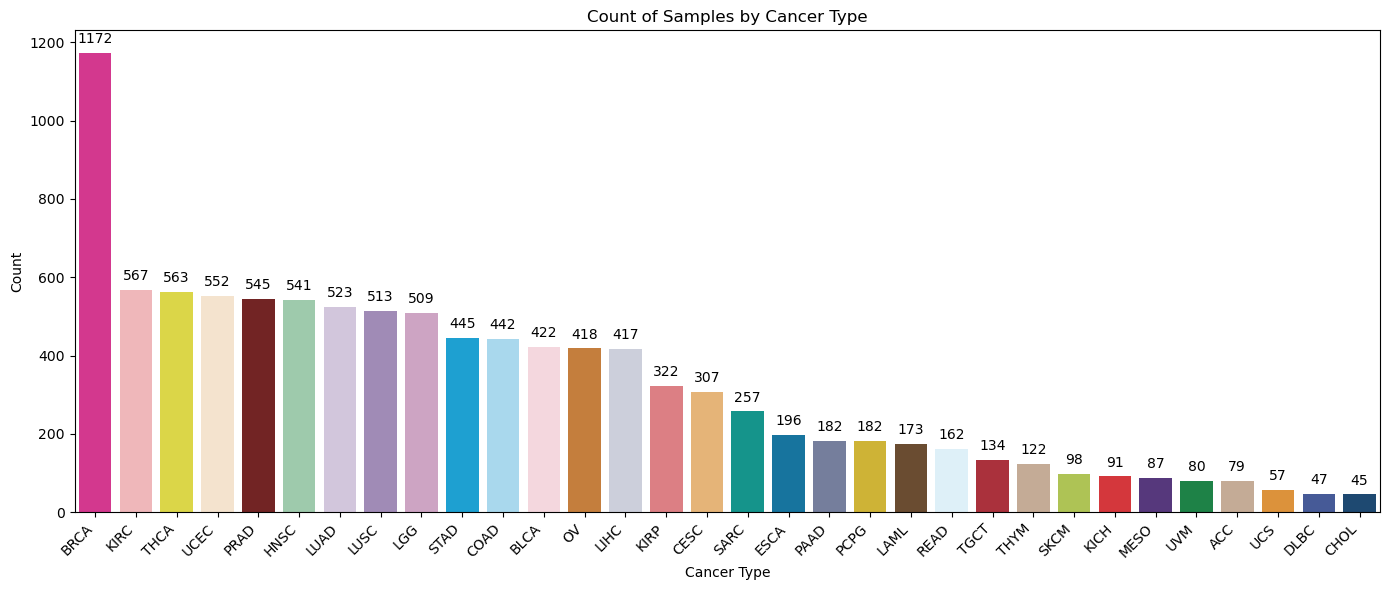

In [10]:
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

In [25]:
def insert_random_na_columns(df, column_name, fraction):
    df_copy = df.copy()
    
    # Ensure column_name is a list
    if isinstance(column_name, str):
        column_name = [column_name]
    
    # Get the number of rows in the DataFrame
    n_rows = len(df_copy)
    a
    # Calculate the number of values to replace
    n_replace = int(n_rows * fraction)
    
    for col in column_name:
        # Randomly select indices to replace
        replace_indices = np.random.choice(df_copy.index, n_replace, replace=False)
        
        # Replace selected values with NaN
        df_copy.loc[replace_indices, col] = np.nan
    
    return df_copy

tcga_mrna = insert_random_na_columns(tcga_mrna, column_name=['FOXG1'], fraction=0.5)

In [26]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [27]:
# make data split for train, validation, and test sets
train_ratio= 0.70
batch_size = 256
scaling_type = 'mean'

# Split data
train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type=scaling_type)
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type=scaling_type)
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type=scaling_type)

# Stratified Sampler
train_sampler = StratifiedBatchSampler(train_dataset.__getlabel__(), batch_size=batch_size)
validation_sampler = StratifiedBatchSampler(validation_dataset.__getlabel__(), batch_size=batch_size)
test_sampler = StratifiedBatchSampler(test_dataset.__getlabel__(), batch_size=batch_size)

# Data Loader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size,
                                           #batch_sampler=train_sampler,
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                #batch_sampler=validation_sampler,
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          #batch_sampler=test_sampler,
                                          shuffle=False,
                                          num_workers=num_workers)

In [28]:
# make data split for train and validation sets
mrna_out_dim = tcga_mrna.shape[1]-4
mirna_out_dim = tcga_mirna.shape[1]-4

In [29]:
print(train_dataset.mrna_data.shape)
print(validation_dataset.mrna_data.shape)
# print(test_dataset.mrna_data.shape)

print(train_dataset.mirna_data.shape)
print(validation_dataset.mirna_data.shape)
# print(test_dataset.mirna_data.shape)

print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([7174, 19741])
torch.Size([1538, 19741])
torch.Size([7174, 2024])
torch.Size([1538, 2024])
19741
2024


In [30]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues = 32
n_tissues

32

# Model Setup

In [31]:
# hyperparameters
latent_dim = 20
hidden_dims = [100, 100, 100]
fc_mrna = 256
fc_mirna = 128
activation = "relu"
reduction_type = "sum" # output loss reduction
r_init_mrna = 2
r_init_mirna = 2
pi_init = 0.5

In [32]:
# Decoder setup
big_mirna = True

# set up an output module for the miRNA expression data

if big_mirna:
    mirna_out_fc = nn.Sequential(
        nn.Linear(hidden_dims[-1], 128),
        get_activation(activation),
        nn.Linear(128, fc_mirna),
        get_activation(activation),
        nn.Linear(fc_mirna, mirna_out_dim))
    output_mirna_layer = ZINB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init_mirna, pi_init=pi_init, scaling_type=scaling_type)
    output_mirna_layer.n_features = mirna_out_dim
else:
    mirna_out_fc = nn.Sequential(
        nn.Linear(hidden_dims[-1], fc_mirna),
        get_activation(activation),
        nn.Linear(fc_mirna, mirna_out_dim))
    output_mirna_layer = ZINB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init_mirna, pi_init=pi_init, scaling_type=scaling_type)
    output_mirna_layer.n_features = mirna_out_dim

# set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 128),
    get_activation(activation),
    nn.Linear(128, fc_mrna),
    get_activation(activation),
    nn.Linear(fc_mrna, mrna_out_dim))
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, r_init=r_init_mrna, scaling_type=scaling_type)
output_mrna_layer.n_features = mrna_out_dim

# set up the decoder
decoder = Decoder(latent_dim, 
                  hidden_dims, 
                  output_module_mirna=output_mirna_layer, 
                  output_module_mrna=output_mrna_layer, 
                  activation=activation).to(device)

# setup gmm init
gmm_mean_scale = 4.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

In [33]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

# Training

In [35]:
learning_rates={'dec':1e-4, 'rep':1e-2, 'gmm':1e-2}
weight_decay={'dec':1e-4, 'rep':1e-4, 'gmm':1e-4}
betas=(0.9, 0.999)
nepochs = 1500
pr = 5 # how often to print epoch
plot = 75 # how often to print plot

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]

print(sample_index)
subset = sample_index[0]

loss_tab = train_midgd(dgd, train_loader, validation_loader, device,
                       learning_rates=learning_rates, weight_decay=weight_decay, betas=betas, 
                       nepochs=nepochs, fold=None, pr=pr, plot=plot, 
                       reduction_type=reduction_type, scaling_type=scaling_type,
                       sample_index=sample_index, subset=subset, wandb_log=False, early_stopping=50, is_plot=False)

[1371, 1304, 34, 359]


  0%|                                                                                                                                                                                                                                                                                                                        | 0/1500 [00:01<?, ?it/s]


ValueError: Expected value argument (Tensor of shape (32, 20)) to be within the support (Real()) of the distribution Normal(loc: 7.377758979797363, scale: 1.0), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       grad_fn=<NegBackward0>)

# Plotting Loss

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon_mirna", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon_mirna", data=loss_tab, label="Test")
plt.title("miRNA reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_recon_mrna", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_recon_mrna", data=loss_tab, label="Test")
plt.title("mRNA reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Display the plots
plt.show()

In [ ]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for R-squared
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for Corr
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman")
plt.xlabel("Epoch")
plt.ylabel("Spearman")

# Third subplot for MSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson")
plt.xlabel("Epoch")
plt.ylabel("Pearson")

# Fourth subplot for MAE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()

# Save Model

In [ ]:
torch.save(dgd, "models/12082024_midgd.pth")